### Some version information

Your versions do not have to be exactly the same, this is just included for reference

In [1]:
import sys
print(f"Python version: {sys.version}")

Python version: 3.10.4 | packaged by conda-forge | (main, Mar 30 2022, 08:38:02) [MSC v.1916 64 bit (AMD64)]


In [7]:
from importlib.metadata import version

for module in ['numpy','matplotlib','scipy']:
    print(module + ': ' + version(module))

numpy: 1.21.5
matplotlib: 3.5.2
scipy: 1.7.3


# 1. The Pendulum

First we look at the motion of a pendulum under gravity when we assume small oscillations and no friction forces. The diagram below (from [here](https://www.acs.psu.edu/drussell/Demos/Pendulum/Pendulum.html)) sets the notation for the problem.

<p align="center">
  <img src="pendulum.jpg" width="22%" height="22%"/>
</p>

The equation of motion is $mL\ddot{\theta} = mg\sin\theta$ which can be rearraged to 
\begin{equation}
\ddot{\theta} = -\frac{g}{L}\sin\theta
\end{equation}

Under the assumption of small oscillations ($\theta \ll 1$), this reduces to 
$$
\ddot{\theta} = -\frac{g}{L}\theta
$$
This equation admits an analytical solution given by

$$\theta(t) = \theta_0 \cos(\omega t)$$

where $\omega = \sqrt{\frac{g}{L}}$. This analytical motion can be easily plotted as follows:

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Following local acceleration due to gravity from 
# https://sciencedemonstrations.fas.harvard.edu/presentations/newtons-apple#:~:text=The%20value%20of%20g%20for,is%209.8038%20m%2Fs2.
# But can we trust Harvard ??
g_cambridge = 9.8038  # In SI units [ms^{-2}]

L = 1.0 # In meters [m]


# Code up the analytical solution, we use the numpydoc format for function docstrings (https://numpydoc.readthedocs.io/en/latest/example.html)
def small_angle_theta(t, theta0 = np.pi/8, omega = np.sqrt(g_cambridge/L)):   # we set some reasonable default values
    """ Angular position of a small angle approximation pendulum of frequency omega at time t

        Parameters
        ----------
        t : array_like  (basically means a number, list of numbers or numpy array of numbers, likely floats in this instance)
            time at which we evaluate the position [seconds]
        theta0 : float
            angular position of pendulum at time t=0 [radians]
        omega : float
            frequency of oscillator [radians per second]

        Returns
        -------
        theta : array_like
            angular position of pendulum at time t [radians]
    """ 
    return theta0 * np.cos(omega*t)

Text(0.5, 1.0, 'Motion of small angle pendulum')

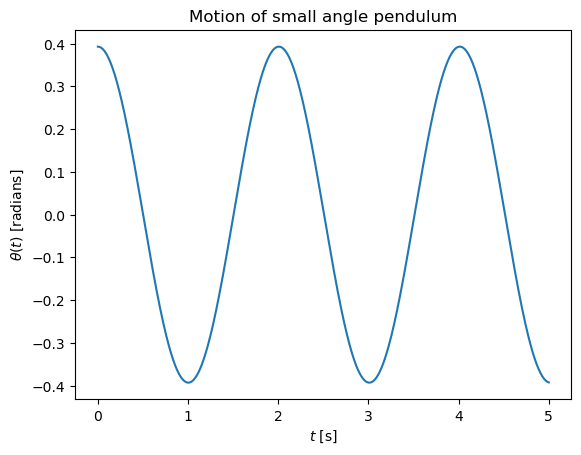

In [38]:
# Make a plot
num_timesteps = 10000

t_values = np.linspace(0, 5, num_timesteps)
small_angle_theta_values = small_angle_theta(t_values)  # numpy operations automatically broadcast calculation over whole array of t values
                                                        # We also use the default values for theta0 and omega

plt.plot(t_values, small_angle_theta_values)
plt.xlabel(r"$t$ [s]")
plt.ylabel(r"$\theta (t)$ [radians]")
plt.title("Motion of small angle pendulum")

One can see the period of osciallation $T = \frac{2\pi}{\omega}$, and that the amplitude is constant as we havent included any friction forces 

# 2. Without small angle approximation
If we dont make the small angle approximation, we must solve the nonlinear equation of motion (equation 1) numerically. This involves some approximate scheme where one takes the current position $\theta(t)$ and updates it to a value later in time by some small timestep $\theta(t + dt)$ using the nonlinear equation of motion.

The numerical scheme we will use is called "Leapfrog integration" (see [this page](https://en.wikipedia.org/wiki/Leapfrog_integration)) because it is lightweight, stable, and doesnt drift away from the true solution over time, as can occur with methods such as the Runge-Kutta methods. The code below is taken from [this page](http://cvarin.github.io/CSci-Survival-Guide/leapfrog.html) which is a much more detailed introduction to leapfrog integration

### 2.1 Reformulating the problem
The first step is to reformulate our second order differential equation in $\theta$ as two first order differential equations, in $\theta$ and $v \vcentcolon=\dot{\theta}$. From equation 1 above we get
$$
\begin{align}
\frac{d\theta}{dt} &= v\\
\frac{dv}{dt} &= -\frac{g}{L}\sin\theta
\end{align}
$$

which is a coupled pair of first order differential equations in $\theta$ and $v$. Note that since $v$ is just an angular speed [radians per second] to convert it to a rate of change of distancce, one must multiply is by L. so the rate of change of position is $Lv$.

### 2.2 The principle of Leapfrog Integration
The basic principle used by leapfrog integration is that we update one variable at timesteps $t_0,t_1,t_3,\dots$ and the other at the half-timesteps between those values, that is $\frac{t_1 - t_0}{2}, \frac{t_2 - t_1}{2}, \dots$ which we can also label $t_{1/2},t_{3/2},t_{5/2},\dots$. For more details see the link above. In the diagram below (from [here](http://www.physics.drexel.edu/~steve/Courses/Comp_Phys/Integrators/leapfrog/)) "x" respresents our "$\theta$"
<p align="center">
  <img src="leapfrog.jpg" width="40%" height="40%"/>
</p>

Using the definition of the derivative and the first of our coupled equations above, we approximate the updated theta values by the following scheme:

$$
\frac{\theta_{n+1} - \theta_{n}}{dt} = v_{n + 1/2} \quad \implies \quad \theta_{n+1} = \theta_n + dt \,v_{n + 1/2}
$$

And for the updated $v$ values, we use the other of our coupled equations to write

$$
\frac{v_{n+1/2} - v_{n-1/2}}{dt} = -\frac{g}{L}\sin(\theta_n) \quad \implies \quad v_{n+1/2} = v_{n - 1/2} - dt\,\frac{g}{L}\sin(\theta_n)
$$

### 2.3 Python implementation of leapfrog integrator
The integrator below is actually a reasonably general leapfrog integrator, as we pass the only problem-specific information (the RHS of the v equation and any problem-specific arguments) in a general manner. As a result, the integrator can be used for many problems

In [49]:
def v_update_pendulum(theta, v, dt, omega=np.sqrt(g_cambridge/L)): # omega is passed to this function by **kwargs below when integrating
    """ RHS of the v update equation for the unforced, undamped pendulum without the small angle approximation (just above)

        Parameters
        ----------
        theta : float
            angular position of pendulum [radians]
        v : float
            angular speed of pendulum [radians per second]
        args : list
            problem-specific arguments, here only omega, the frequency of the small angle approximation pendulum (sqrt{g/L})

        Returns
        -------
        v_updated : float
            value of v at next timestep [radians per second]
    """

    # calculate updated v
    v_updated = v - dt * np.power(omega,2) * np.sin(theta)

    return v_updated 

def integrate(v_update_function, t, theta0=0, v0=0.0, **kwargs): # kwargs is by default an empty dictionary of problem-specific keyword arguments
    """ Integrate the motion of a pendulum under the influence of gravity without the small angle approximation, using leapfrog integration

        Parameters
        ----------
        v_update_function : function
            function describing the RHS of the v update equation, where v = \dot{theta}
        t : array
            uniformly spaced timesteps at which we want the solution theta(t) and v(t) [seconds]
        theta0 : float
            angular position of pendulum at time t=0 [radians]
        v0 : float
            velocity of pendulum in theta direction at time t=0 [radians per second]
        omega : float
            frequency of the small angle approximation oscillator (sqrt{g/L}) [radians per second]

        Returns
        -------
        theta_values : array_like
            angular position of pendulum at times t [radians]
        v_values : array_like
            angular speed of pendulum at times t [radians per second]
    """
    # Time step information
    N = len(t)
    dt = t[1] - t[0]

    # arrays are allocated and filled with zeros
    theta_values = np.zeros(N)
    v_values = np.zeros(N)

    # initial conditions
    theta_values[0] = theta0
    v_values[0] = v0
    
    # integration
    for i in range(N-1):
        v_values[i + 1] = v_update_function(theta=theta_values[i], v=v_values[i], dt=dt, **kwargs) # the ** unpacks dictionary of problem-specific keyword arguments (kwargs)
        theta_values[i + 1] = theta_values[i] + dt*v_values[i + 1]
    
    # return solution
    return theta_values, v_values

### 2.4 Perform the integration

In [63]:
theta0 = np.pi/5
omega = np.sqrt(g_cambridge/L) # already the default value, but plugging it into the functions for demonstration purposes

theta, v = integrate(v_update_pendulum, t_values, theta0=theta0, omega=omega) # no small angle approx
small_angle_theta_values = small_angle_theta(t_values, theta0=theta0, omega=omega) # small angle approx

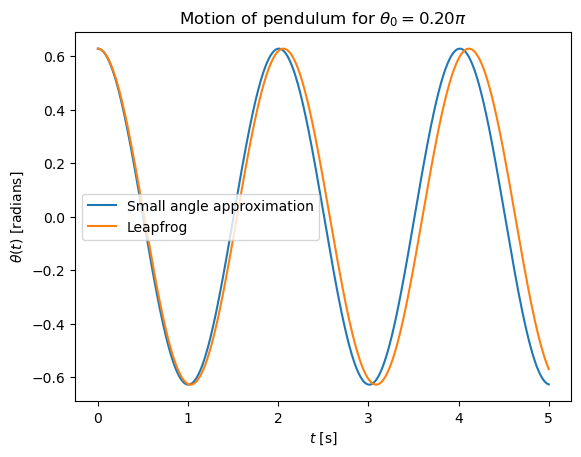

In [64]:
fig = plt.figure()

plt.plot(t_values, small_angle_theta_values, label = "Small angle approximation")
plt.plot(t_values, theta, label = "Leapfrog")
plt.xlabel(r"$t$ [s]")
plt.ylabel(r"$\theta (t)$ [radians]")
plt.title(r"Motion of pendulum for $\theta_0={:.2f}\pi$".format(theta0/np.pi))
plt.legend()

Now repeat for a large initial angle

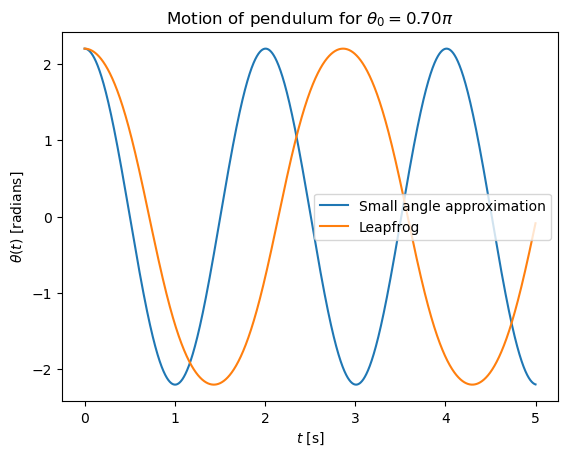

In [62]:
large_theta0 = 0.7*np.pi

small_angle_theta_values = small_angle_theta(t_values, theta0=large_theta0) # use default value for omega
theta, v = integrate(v_update_pendulum, t_values, theta0=large_theta0) # use default value for omega

fig = plt.figure()

plt.plot(t_values, small_angle_theta_values, label = "Small angle approximation")
plt.plot(t_values, theta, label = "Leapfrog")
plt.xlabel(r"$t$ [s]")
plt.ylabel(r"$\theta (t)$ [radians]")
plt.title(r"Motion of pendulum for $\theta_0={:.2f}\pi$".format(large_theta0/np.pi))
plt.legend()